#### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

##### Import Libraries

In [21]:
#import libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [12]:
data_dir_train = pathlib.Path("/Users/jyotirmoyghosh/Downloads/Melanoma/Train/")
data_dir_test = pathlib.Path("/Users/jyotirmoyghosh/Downloads/Melanoma/Test/")

In [13]:
#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [15]:
# Set Parameters
batch_size = 32
img_height = 180
img_width = 180

In [16]:
# Create Train/Test Dataset
#Train datset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="training",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [17]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="validation",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [18]:
# Check the classes
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Data Visualization

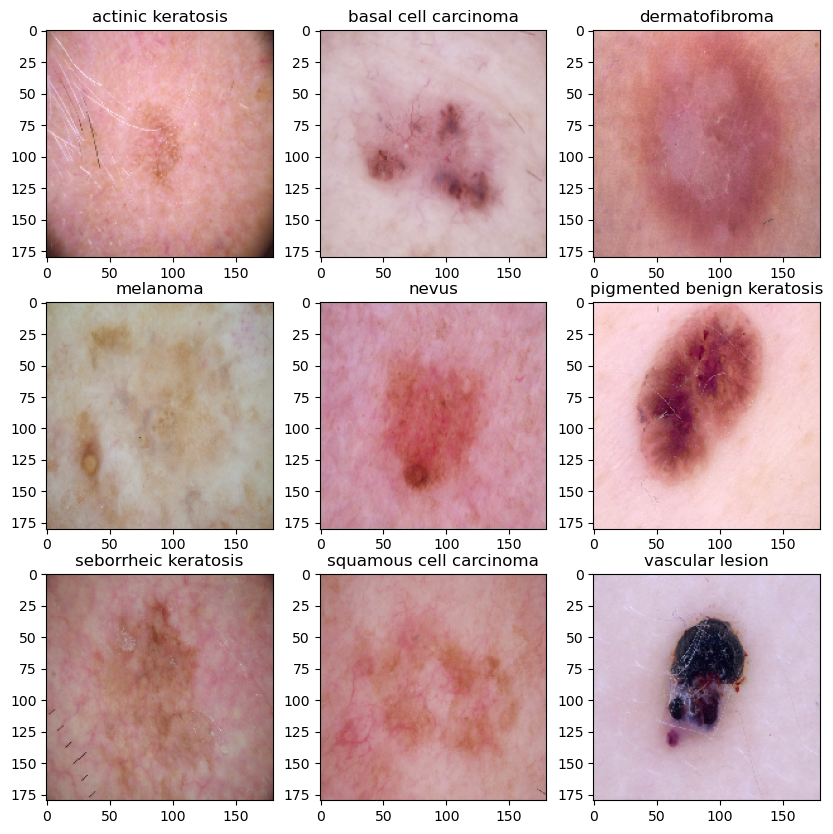

In [55]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Plot image 
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)

In [24]:
# Optimize execution

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation

In [25]:
input_shape = (img_height,img_width,3)

model = Sequential()  

#Conv layer 1
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Conv layer 2
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Conv layer 3
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten()) 

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
model.add(layers.Dense(len(class_names),activation='softmax'))

In [26]:
## Compile the model using Adam optimization; cross entropy loss

model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Model Training

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 26s 383ms/step - loss: 2.0923 - accuracy: 0.2098 - val_loss: 1.9764 - val_accuracy: 0.2438
Epoch 2/20
56/56 [==============================] - 20s 360ms/step - loss: 1.8533 - accuracy: 0.3253 - val_loss: 1.6300 - val_accuracy: 0.4564
Epoch 3/20
56/56 [==============================] - 20s 361ms/step - loss: 1.5779 - accuracy: 0.4481 - val_loss: 1.4212 - val_accuracy: 0.5213
Epoch 4/20
56/56 [==============================] - 20s 364ms/step - loss: 1.4578 - accuracy: 0.4927 - val_loss: 1.3683 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 20s 362ms/step - loss: 1.3670 - accuracy: 0.5128 - val_loss: 1.3848 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 20s 361ms/step - loss: 1.2773 - accuracy: 0.5312 - val_loss: 1.3799 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 20s 362ms/step - loss: 1.2234 - accuracy: 0.5653 - val_loss: 1.4543 - val_accuracy: 0.5302

### Visualize training results

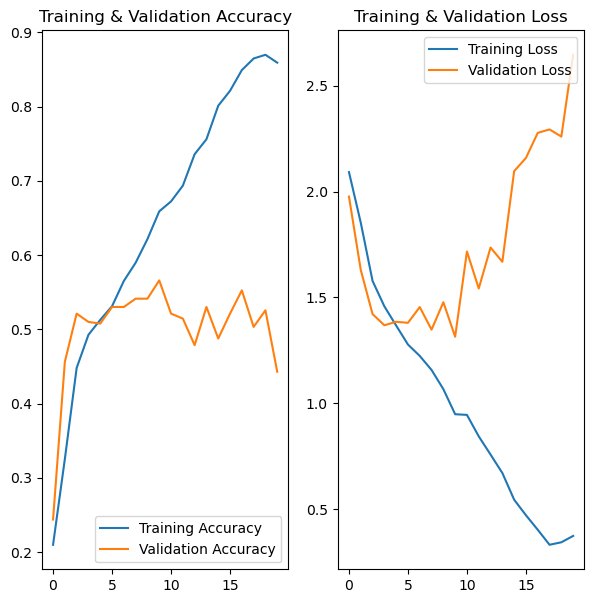

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.show()

#### From the above its clear that model is overfitting. With increase in epoch the difference between training accuracy and validation accuracy increases.

#### Need to do data augementation

In [30]:
rescale = tf.keras.Sequential([  
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    
  # Rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.2),
    
  # Zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.2),
    
  # Translate each image during training.
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)    
])

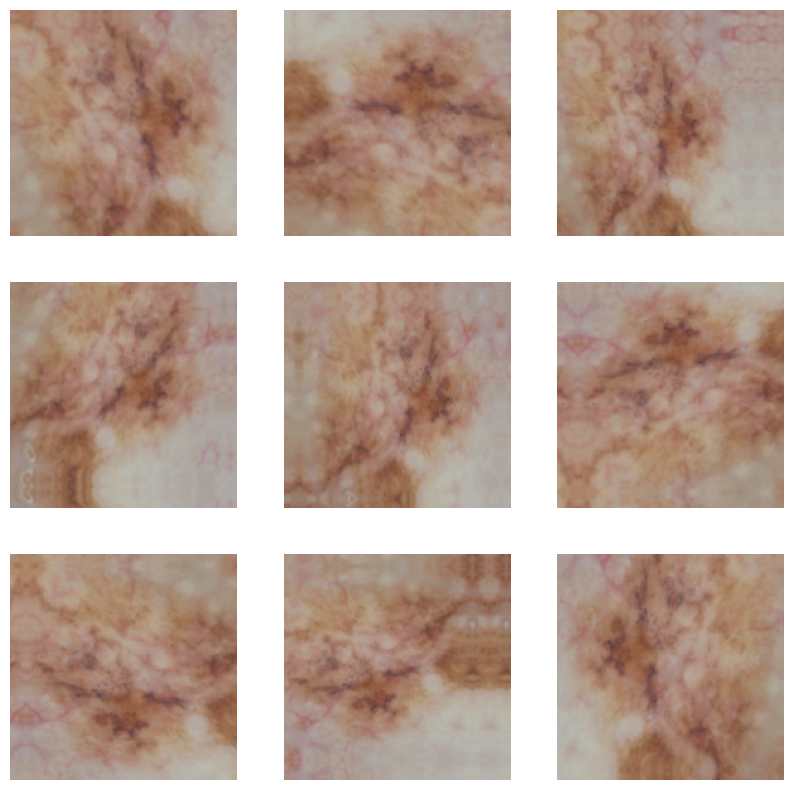

In [31]:
## Visualize the data

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):   
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")       

In [32]:
## Model 2 Creation

model2 = Sequential()                      

model2.add(data_augmentation)             
model2.add(rescale)                       

# Conv Layer 1
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25%
model2.add(layers.Dropout(0.25))

#Conv Layer 2
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25%
model2.add(layers.Dropout(0.25))

# Conv Layer 3
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

# Flatten
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50%
model2.add(layers.Dropout(0.50))

# Use softmax activation function.
model2.add(layers.Dense(len(class_names),activation='softmax'))

#### Compile the model

In [33]:
model2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#### Model Training

In [35]:
epochs =20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/20
56/56 [==============================] - 24s 408ms/step - loss: 2.4918 - accuracy: 0.1942 - val_loss: 2.1220 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 22s 400ms/step - loss: 2.0548 - accuracy: 0.1886 - val_loss: 2.0278 - val_accuracy: 0.2662
Epoch 3/20
56/56 [==============================] - 22s 402ms/step - loss: 1.9080 - accuracy: 0.2980 - val_loss: 1.7928 - val_accuracy: 0.3826
Epoch 4/20
56/56 [==============================] - 22s 397ms/step - loss: 1.7916 - accuracy: 0.3504 - val_loss: 1.6674 - val_accuracy: 0.4116
Epoch 5/20
56/56 [==============================] - 22s 397ms/step - loss: 1.7642 - accuracy: 0.3560 - val_loss: 1.7291 - val_accuracy: 0.3423
Epoch 6/20
56/56 [==============================] - 22s 399ms/step - loss: 1.7464 - accuracy: 0.3717 - val_loss: 1.7258 - val_accuracy: 0.3826
Epoch 7/20
56/56 [==============================] - 22s 398ms/step - loss: 1.6909 - accuracy: 0.3873 - val_loss: 1.7110 - val_accuracy: 0.4407

#### Visualize the results of 2nd model

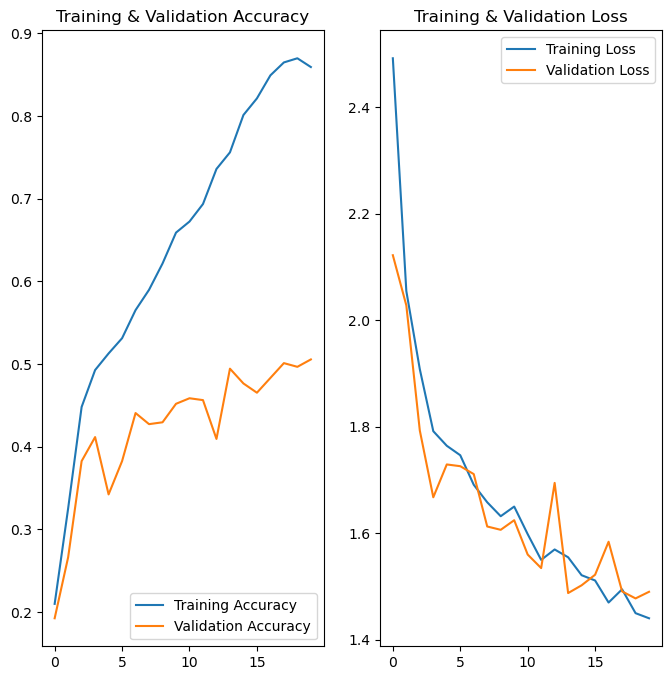

In [36]:
cc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.show()

#### Model overfitting is reduced with data augementation and drop out layer. However model performance has not increased.

#### Let's look at class imbalance

In [37]:
def class_distribution_count(directory):
    
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    

    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

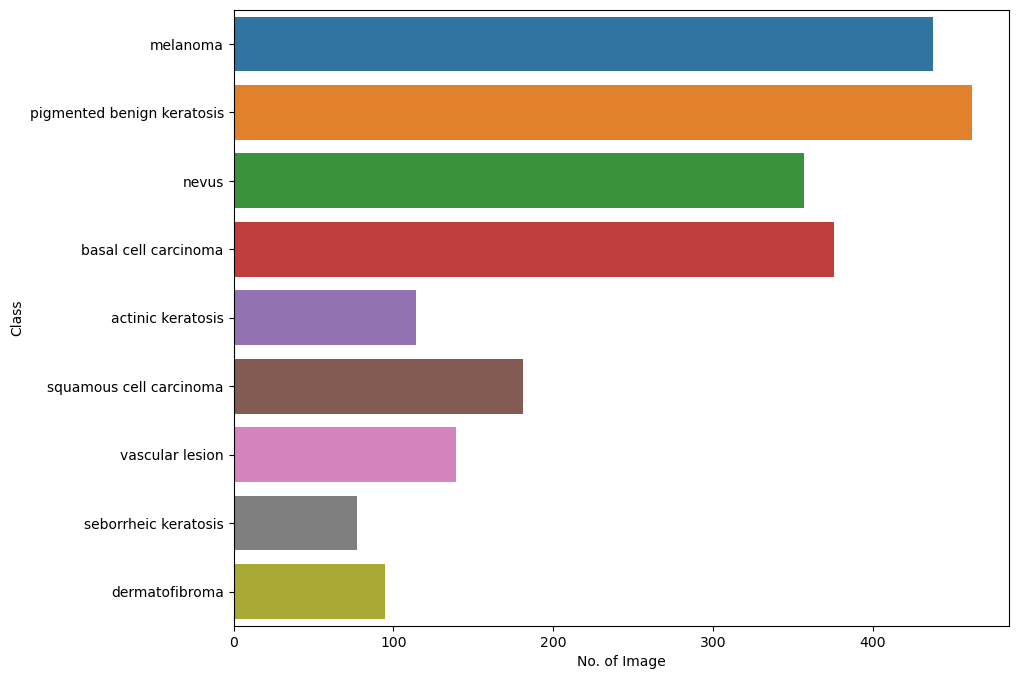

In [38]:
## Let's visualize the classes

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

### Observation
    seborrheic keratosis has the least number of samples only 77.
    pigmented benign keratosis (462 Samples), melanoma (438 Samples), basal cell carcinoma (376 Samples), and nevus (357 Samples) classes dominates the data in terms proportionate number of samples.

### Class Imbalance rectification using Augmentor

In [39]:
!pip install Augmentor

In [40]:
## Add 500 samples to each class
path_to_training_dataset="/Users/jyotirmoyghosh/Downloads/Melanoma/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Initialised with 114 image(s) found.
Output directory set to /Users/jyotirmoyghosh/Downloads/Melanoma/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2


Initialised with 376 image(s) found.
Output directory set to /Users/jyotirmoyghosh/Downloads/Melanoma/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x151356B10>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to /Users/jyotirmoyghosh/Downloads/Melanoma/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28E449890>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to /Users/jyotirmoyghosh/Downloads/Melanoma/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2126x2185 at 0x28E3C0C50>: 100%|


Initialised with 357 image(s) found.
Output directory set to /Users/jyotirmoyghosh/Downloads/Melanoma/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=959x634 at 0x15DC73810>: 100%|█|


Initialised with 462 image(s) found.
Output directory set to /Users/jyotirmoyghosh/Downloads/Melanoma/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16E7F5710>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to /Users/jyotirmoyghosh/Downloads/Melanoma/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x177D46210>: 100%|█


Initialised with 181 image(s) found.
Output directory set to /Users/jyotirmoyghosh/Downloads/Melanoma/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x177D53590>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to /Users/jyotirmoyghosh/Downloads/Melanoma/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15E3CE9D0>: 100%|█|


In [41]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [42]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [44]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [45]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

#label count.
df2['Label'].value_counts()

### Train the model using the additional data created by Augmentor

In [47]:
batch_size = 32
img_height = 180
img_width = 180

In [48]:
data_dir_train="/Users/jyotirmoyghosh/Downloads/Melanoma/Train/" 

#Training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,   
  subset = "training",
  image_size=(img_height, img_width),label_mode='categorical',  
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [49]:
#Test dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),label_mode='categorical',  
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Model creation

In [50]:
model3 = Sequential()

model3.add(rescale)  

# Conv Layer 1
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

# Conv Layer 2
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

# Conv Layer 3
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% 
model3.add(layers.Dropout(0.50))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model

In [51]:
model3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#### Train the model

In [52]:
epochs = 50
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/50
169/169 [==============================] - 52s 302ms/step - loss: 2.3765 - accuracy: 0.1971 - val_loss: 4.6054 - val_accuracy: 0.0898
Epoch 2/50
169/169 [==============================] - 50s 296ms/step - loss: 1.8514 - accuracy: 0.3134 - val_loss: 2.6320 - val_accuracy: 0.2717
Epoch 3/50
169/169 [==============================] - 51s 296ms/step - loss: 1.5792 - accuracy: 0.4026 - val_loss: 1.8728 - val_accuracy: 0.2524
Epoch 4/50
169/169 [==============================] - 51s 296ms/step - loss: 1.4802 - accuracy: 0.4444 - val_loss: 1.5191 - val_accuracy: 0.3756
Epoch 5/50
169/169 [==============================] - 50s 295ms/step - loss: 1.3775 - accuracy: 0.4794 - val_loss: 1.8829 - val_accuracy: 0.2769
Epoch 6/50
169/169 [==============================] - 50s 296ms/step - loss: 1.3063 - accuracy: 0.5117 - val_loss: 1.7002 - val_accuracy: 0.3667
Epoch 7/50
169/169 [==============================] - 50s 296ms/step - loss: 1.2578 - accuracy: 0.5436 - val_loss: 1.5294 - val_ac

#### Validate Results

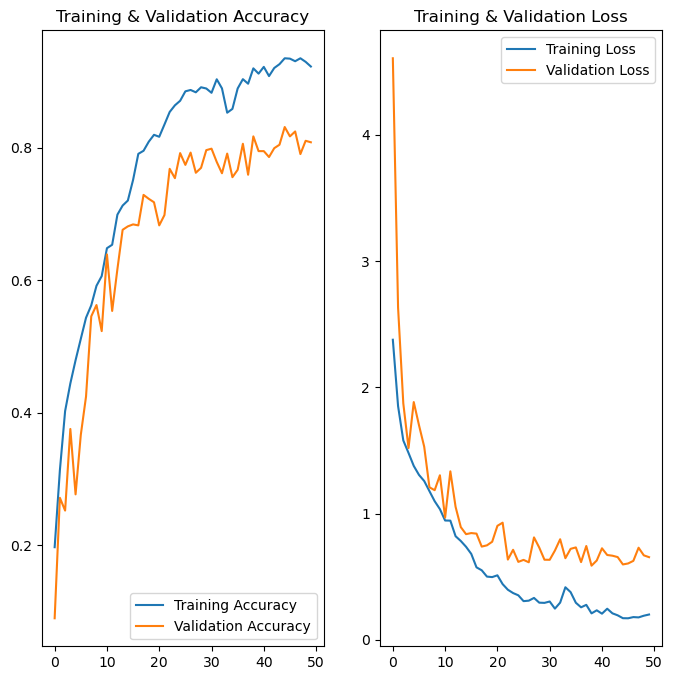

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.show()

### Model 3 Observation
    1. Overfitting issue seems to be resolved using Augmentor
    2. Training and Validation accuracy has increased